In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import IPython.display as display
from PIL import Image # 需要先安装 pip install Pillow

In [2]:
import pathlib
# # get_file() 默认情况下，URL中的文件origin下载到cache_dir ~/.keras，放在cache_subdir中datasets，并指定文件名fname。
# # 返回下载文件的路径。
# data_dir = tf.keras.utils.get_file(fname='flower_photos', # 指定文件名
#                                    origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
#                                    untar=True, #布尔值，是否应该解压缩文件
#                                    )  


data_dir = 'C:/Users/34123/.keras/datasets/flower_photos'
data_dir = pathlib.Path(data_dir)

In [3]:
data_dir

WindowsPath('C:/Users/34123/.keras/datasets/flower_photos')

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [6]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

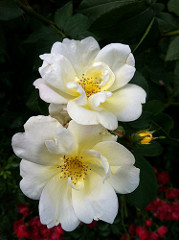

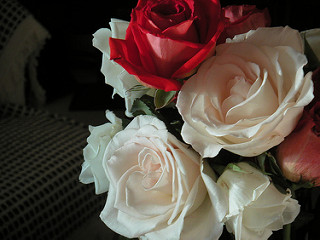

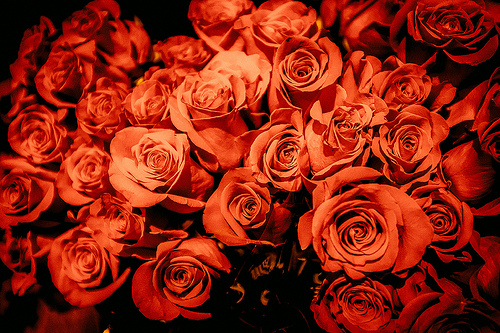

In [7]:
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

In [8]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [9]:
# 为加载程序定义一些参数：
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [10]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 3670 images belonging to 5 classes.


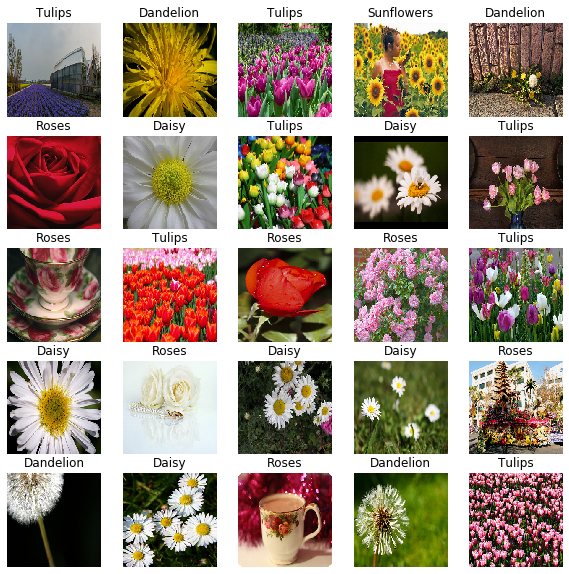

In [11]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')
        
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [12]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [13]:
for f in list_ds.take(5):
    print(f.numpy())

b'C:\\Users\\34123\\.keras\\datasets\\flower_photos\\dandelion\\570127230_ce409f90f8_n.jpg'
b'C:\\Users\\34123\\.keras\\datasets\\flower_photos\\sunflowers\\7820398908_4316bbba45.jpg'
b'C:\\Users\\34123\\.keras\\datasets\\flower_photos\\tulips\\3238068295_b2a7b17f48_n.jpg'
b'C:\\Users\\34123\\.keras\\datasets\\flower_photos\\sunflowers\\20407896403_a50fef58ac_n.jpg'
b'C:\\Users\\34123\\.keras\\datasets\\flower_photos\\sunflowers\\14741812319_e1d32ffb84_n.jpg'


Windows中文件路径分隔符是 '\\'，Linux是 '/'。为了让代码在不同的平台上都能运行，os.sep 根据所处的平台，自动采用相应的分隔符号。

- tf.strings.split
- https://www.tensorflow.org/api_docs/python/tf/strings/split

- tf.io.decode_jpeg
- https://www.tensorflow.org/api_docs/python/tf/io/decode_jpeg

- tf.image.convert_image_dtype
- https://www.tensorflow.org/api_docs/python/tf/image/convert_image_dtype

In [15]:
# 以下三个自定义函数实现将文件路径转换为(img, label)元组
def get_label(file_path):
    '''
    该函数实现从根目录获取分类名
    '''
    # 将路径按照定界符（sep，第二个参数）拆分为组成路径的元素，返回一个列表；
    parts = tf.strings.split(file_path, os.path.sep)
    # 图片路径格式为：C:\Users\34123\.keras\datasets\flower_photos\daisy\...；
    # 因此列表中导数第二个元素为文件夹名称，也是分类名称；
    return parts[-2] == CLASS_NAMES

def decode_img(img):
    '''
    该函数实现将图片转化为3D tensor，并且调整图片为指定大小
    '''
    # 将JPEG编码的图像解码为3D uint8张量
    img = tf.image.decode_jpeg(img, channels=3)
    # 转换image为dtype，根据需要缩放其值到 [0,1] 范围内.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 调整图片到指定大小.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
    '''
    该函数实现将指定路径下的图片组合为（图片，标签）元组
    '''
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

- Dataset.map
- https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map
- num_parallel_calls：（可选。）tf.int32标量tf.Tensor，表示要并行异步处理的数字元素。如果未指定，则将按顺序处理元素。  tf.data.experimental.AUTOTUNE，那么将根据可用的CPU动态设置并行调用的次数。

In [17]:
# 设置“ num_parallel_calls”，以便并行加载/处理多个图像。
labeled_ds = list_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [18]:
# tf.Dataset.take(count)方法实现从数据集中提取count个元素 
for image, label in labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False False False False  True]


# 训练的基本方法
要使用此数据集训练模型，需要对数据做如下处理：
- 随机打乱数据（shuffle）
- 批处理数据（batch）
- 尽可能快的批处理数据

使用tf.data api可以轻松实现以上功能。

In [28]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # 这是一个小数据集，只加载一次，并保存在内存中。
    # 使用`.cache（filename）`缓存不适合内存的数据集 进行预处理。
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    
    # 打乱数据
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # 重复数据
    ds = ds.repeat()
    # 每次去一个批次数据
    ds = ds.batch(BATCH_SIZE)

    #“prefetch”允许数据集在模型训练时在后台提取批。
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return ds

In [29]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

In [30]:
train_ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 5)), types: (tf.float32, tf.bool)>

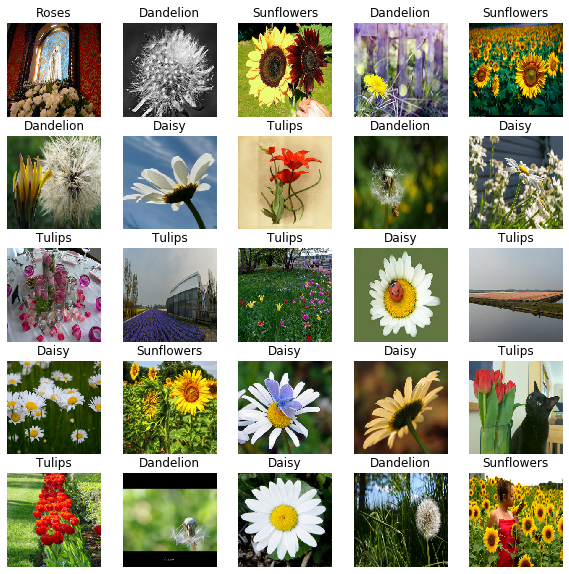

In [21]:
show_batch(image_batch.numpy(), label_batch.numpy())

# 检查tf读取数据的性能

In [31]:
import time
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
    start = time.time()
    it = iter(ds)
    for i in range(steps):
        batch = next(it)
        if i%10 == 0:
            print('.',end='')
    
    print()
    end = time.time()

    duration = end-start
    print("{} batches: {} s".format(steps, duration))
    print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))

In [32]:
# keras.preprocessing
timeit(train_data_gen)

....................................................................................................
1000 batches: 95.04578709602356 s
336.67984 Images/s


In [33]:
# tf.data
timeit(train_ds)

....................................................................................................
1000 batches: 29.184619188308716 s
1096.46796 Images/s


In [34]:
# 性能提高的很大一部分来自使用.cache
uncached_ds = prepare_for_training(labeled_ds, cache=False)
timeit(uncached_ds)

....................................................................................................
1000 batches: 52.8910551071167 s
605.01724 Images/s


In [35]:
# 如果数据集无法一次加载到内存中，可使用缓存文件来保持性能
filecache_ds = prepare_for_training(labeled_ds, cache="./flowers.tfcache")
timeit(filecache_ds)

....................................................................................................
1000 batches: 102.5016496181488 s
312.19010 Images/s


In [57]:
# 下载数据集
csv_file = tf.keras.utils.get_file('heart.csv', 'https://storage.googleapis.com/applied-dl/heart.csv')
# 使用pandas读取为 DataFrame格式
df = pd.read_csv(csv_file)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [58]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal         object
target        int64
dtype: object

In [59]:
df['thal'] = pd.Categorical(df['thal'])

In [60]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [61]:
df.dtypes

age            int64
sex            int64
cp             int64
trestbps       int64
chol           int64
fbs            int64
restecg        int64
thalach        int64
exang          int64
oldpeak      float64
slope          int64
ca             int64
thal        category
target         int64
dtype: object

In [64]:
df.thal

0           fixed
1          normal
2      reversible
3          normal
4          normal
          ...    
298         fixed
299    reversible
300    reversible
301    reversible
302    reversible
Name: thal, Length: 303, dtype: category
Categories (5, object): [1, 2, fixed, normal, reversible]

In [65]:
df.thal.cat.codes

0      2
1      3
2      4
3      3
4      3
      ..
298    2
299    4
300    4
301    4
302    4
Length: 303, dtype: int8

In [66]:
df['thal'] = df.thal.cat.codes

In [67]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,2,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,4,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


- tf.data.Dataset.from_tensor_slices
- https://tensorflow.google.cn/api_docs/python/tf/data/Dataset#from_tensor_slices

In [68]:
target = df.pop('target')
dataset = tf.data.Dataset.from_tensor_slices((df.values, target.values))

In [69]:
for feat, targ in dataset.take(5):
    print ('Features: {}Target: {}'.format(feat, targ))

Features: [ 63.    1.    1.  145.  233.    1.    2.  150.    0.    2.3   3.    0.
   2. ]Target: 0
Features: [ 67.    1.    4.  160.  286.    0.    2.  108.    1.    1.5   2.    3.
   3. ]Target: 1
Features: [ 67.    1.    4.  120.  229.    0.    2.  129.    1.    2.6   2.    2.
   4. ]Target: 0
Features: [ 37.    1.    3.  130.  250.    0.    0.  187.    0.    3.5   3.    0.
   3. ]Target: 0
Features: [ 41.    0.    2.  130.  204.    0.    2.  172.    0.    1.4   1.    0.
   3. ]Target: 0


In [70]:
tf.constant(df['thal'])

<tf.Tensor: shape=(303,), dtype=int32, numpy=
array([2, 3, 4, 3, 3, 3, 3, 3, 4, 4, 2, 3, 2, 4, 4, 3, 4, 3, 3, 3, 3, 3,
       3, 4, 4, 3, 3, 3, 3, 4, 3, 4, 3, 4, 3, 3, 4, 2, 4, 3, 4, 3, 4, 4,
       2, 3, 3, 4, 3, 3, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 4,
       4, 2, 3, 3, 4, 3, 4, 3, 3, 4, 4, 3, 3, 4, 4, 3, 3, 3, 3, 4, 4, 4,
       3, 3, 4, 3, 4, 4, 3, 4, 3, 3, 3, 4, 3, 4, 4, 3, 3, 4, 4, 4, 4, 4,
       3, 3, 3, 3, 4, 3, 4, 3, 4, 4, 3, 3, 2, 4, 4, 2, 3, 3, 4, 4, 3, 4,
       3, 3, 4, 2, 4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
       4, 3, 3, 3, 4, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 2,
       4, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 2, 2, 4, 3, 4, 2, 4, 3,
       3, 4, 3, 3, 3, 3, 4, 3, 4, 3, 4, 2, 2, 4, 3, 4, 3, 2, 4, 3, 3, 2,
       4, 4, 4, 4, 3, 0, 3, 3, 3, 3, 1, 4, 3, 3, 3, 4, 3, 4, 3, 3, 3, 4,
       3, 3, 4, 4, 4, 4, 3, 3, 4, 3, 4, 3, 4, 4, 3, 4, 4, 3, 4, 4, 3, 3,
     

In [71]:
train_dataset = dataset.shuffle(len(df)).batch(1)

In [72]:
def get_compiled_model():
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return model

In [73]:
model = get_compiled_model()
model.fit(train_dataset, epochs=15)

Train for 303 steps
Epoch 1/15
303/303 [==============================] - 5s 16ms/step - loss: 1.5938 - accuracy: 0.6436
Epoch 2/15
303/303 [==============================] - 1s 4ms/step - loss: 0.5250 - accuracy: 0.7162
Epoch 3/15
303/303 [==============================] - 1s 4ms/step - loss: 0.5275 - accuracy: 0.7261
Epoch 4/15
303/303 [==============================] - 1s 4ms/step - loss: 0.5271 - accuracy: 0.7294
Epoch 5/15
303/303 [==============================] - 1s 4ms/step - loss: 0.5094 - accuracy: 0.7360
Epoch 6/15
303/303 [==============================] - 1s 4ms/step - loss: 0.4908 - accuracy: 0.7459
Epoch 7/15
303/303 [==============================] - 1s 4ms/step - loss: 0.4644 - accuracy: 0.7591
Epoch 8/15
303/303 [==============================] - 1s 4ms/step - loss: 0.4599 - accuracy: 0.7591
Epoch 9/15
303/303 [==============================] - 1s 4ms/step - loss: 0.4530 - accuracy: 0.7657
Epoch 10/15
303/303 [==============================] - 1s 4ms/step - loss: 0.43